In [1]:
import os 
import numpy as np 
from astropy.io import fits 
from astropy.modeling import models 

from petrofit.utils import measure_fwhm
from petrofit.fitting import fit_model, model_to_image
from scipy.special import gammaincinv

In [2]:
%matplotlib inline

from matplotlib import pyplot as plt

#plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['image.origin'] = 'lower'
#plt.rcParams.update({'font.size': 17})

SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def savefig(filename):
    plt.savefig("plots/"+filename, dpi=70, bbox_inches = 'tight', pad_inches = 0.1)

# Model Moffat PSF 

In [3]:
real_psf = fits.getdata('../hlsp_frontier_hst60mas_macs0416_v1.0_drz_f105w_psf.fits')

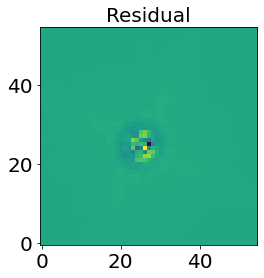

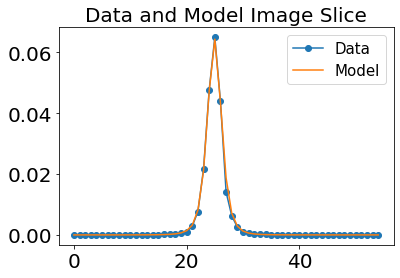

In [4]:
fitted_moffat, _ = fit_model(real_psf, models.Moffat2D())
fitted_psf = model_to_image(27,27,56, fitted_moffat)[1:, 1:]


plt.imshow(real_psf - fitted_psf)
plt.title('Residual')
plt.show()
plt.close()

plt.plot(real_psf[25], marker='o', label="Data")
plt.plot(fitted_psf[25], label='Model')
plt.title('Data and Model Image Slice')
plt.legend()
plt.show()
plt.close()


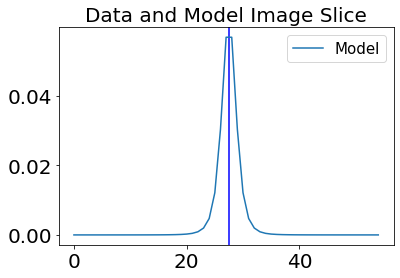

In [5]:
final_moffat = fitted_moffat.copy()

final_moffat.x_0 = 27.5
final_moffat.y_0 = 27.5

final_psf = model_to_image(28,28,56, final_moffat)[:-1, :-1]

final_psf_mid = int(final_moffat.x_0.value)

plt.axvline(final_moffat.x_0.value, c='b')
plt.plot(final_psf[final_psf_mid], label='Model')
plt.title('Data and Model Image Slice')
plt.legend()
plt.show()
plt.close()

In [6]:
#assert sum([i == 25 for i in np.unravel_index(final_psf.argmax(), final_psf.shape)])

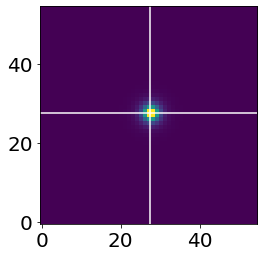

In [7]:
plt.imshow(final_psf)
plt.axvline(final_moffat.x_0.value, c='w')
plt.axhline(final_moffat.y_0.value, c='w')

Normalize PSF 

In [8]:
final_psf = final_psf/final_psf.sum()

In [9]:
fits.writeto('f105_moffat_psf.fits.gz', final_psf, overwrite=True)

# GalFit Simulation

### Plate scale

In [10]:
url = 'https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0/hlsp_frontier_hst_wfc3-60mas_abell2744_f105w_v1.0_drz.fits'

In [11]:
fits.getheader(url)["D001SCAL"]

0.05999999999999999

### GalFit Model Template

In [12]:
# output psf_file size_x size_y size_x size_y x_0 y_0 r_eff n b/a pa
galfit_model_template = """===============================================================================
# IMAGE and GALFIT CONTROL PARAMETERS
A) none           # Input data image (FITS file)
B) {}       # Output data image block
C) none               # Sigma image name (made from data if blank or "none") 
D) {}   #        # Input PSF image and (optional) diffusion kernel
E) 1                   # PSF fine sampling factor relative to data 
F) none                # Bad pixel mask (FITS image or ASCII coord list)
G) none                # File with parameter constraints (ASCII file) 
H) 1    {}   1    {} # Image region to fit (xmin xmax ymin ymax)
I) {} {}         # Size of the convolution box (x y)
J) 26.563              # Magnitude photometric zeropoint 
K) 0.06 0.06                # Plate scale (dx dy)    [arcsec per pixel]
O) regular             # Display type (regular, curses, both)
P) 1                   # Choose: 0=optimize, 1=model, 2=imgblock, 3=subcomps

# INITIAL FITTING PARAMETERS
#
#   For object type, the allowed functions are: 
#       nuker, sersic, expdisk, devauc, king, psf, gaussian, moffat, 
#       ferrer, powsersic, sky, and isophote. 
#  
#   Hidden parameters will only appear when they're specified:
#       C0 (diskyness/boxyness), 
#       Fn (n=integer, Azimuthal Fourier Modes),
#       R0-R10 (PA rotation, for creating spiral structures).
# 
# -----------------------------------------------------------------------------
#   par)    par value(s)    fit toggle(s)    # parameter description 
# -----------------------------------------------------------------------------

# Object number: 1
 0) sersic                 #  object type
 1) {} {}       1 1          #  position x, y
 3) 26.563      1          #  Integrated magnitude	
 4) {}          1          #  R_e (half-light radius)   [pix]
 5) {}          1          #  Sersic index n (de Vaucouleurs n=4) 
 6) 0.0000      0          #     ----- 
 7) 0.0000      0          #     ----- 
 8) 0.0000      0          #     ----- 
 9) {}          1          #  axis ratio (b/a)  
10) {}          1          #  position angle (PA) [deg: Up=0, Left=90]
 Z) 0                      #  output option (0 = resid., 1 = Don't subtract) 


================================================================================"""

In [13]:
# output psf_file size_x size_y size_x size_y x_0 y_0 r_eff n b/a pa

In [14]:
size = 900
commands = []
name_pattern = 'galfit_simulated_sersic_n{}_psf'
for n in [0.5, 1, 4, 5]:
    file_pattern = name_pattern.format(n)
    
    params = galfit_model_template.format(
        file_pattern + '.fits',
        'f105_moffat_psf.fits',
        size,size,size,size,
        size//2+1, size//2+1,
        15,
        n,
        1.,
        0.
    )
    
    
    with open(file_pattern + '.feedme', 'w') as f:
        f.write(params)
    commands.append('echo '+ file_pattern)    
    commands.append('./galfit '+file_pattern+ '.feedme')

with open(name_pattern.format('')+'_bash.sh', 'w') as f:
    f.write('\n'.join(commands))
print('done')

done


### Run `bash ./galfit_simulated_sersic_n_psf_bash.sh` in terminal